<a href="https://colab.research.google.com/github/ohilikeit/PUBG_dataset_project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Load

In [31]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

raw_data = pd.read_csv('/content/drive/MyDrive/project1/data.csv')

# EDA

## (1) Kills
사람들은 얼마나 킬을 했고 데미지를 넣었는가

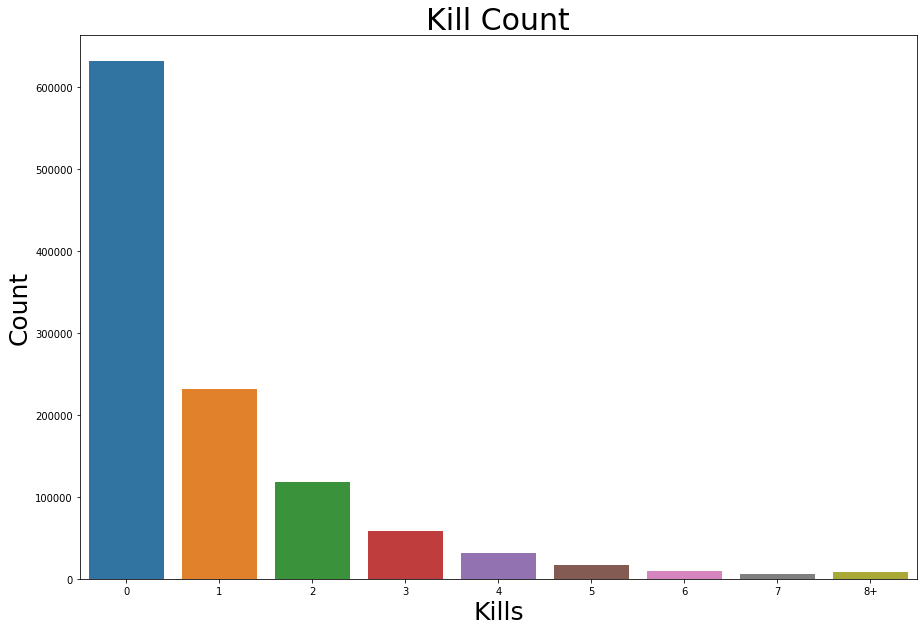

In [2]:
df = raw_data.copy()
df.loc[df['kills'] > df['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(15,10))
sns.countplot(df['kills'].astype('str').sort_values())
plt.title('Kill Count', fontsize=30)
plt.xlabel('Kills', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.show()

 반 이상의 사람들이 1킬도 하지 못한채 죽었다. 그렇다면 킬을 하지 못한 사람들은 총기로 데미지를 얼마나 넣었을까.

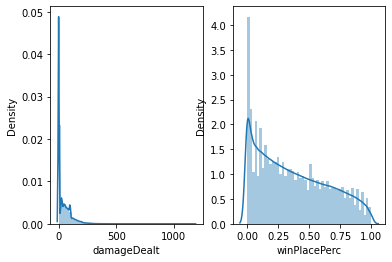

In [3]:
df = df[df['kills'] == 0]
fig, ax = plt.subplots(ncols=2)
sns.distplot(df['damageDealt'], ax=ax[0])
sns.distplot(df['winPlacePerc'], ax=ax[1])

킬을 못한 사람들은 데미지 역시 많이 넣지 못했다. 하지만 그에 비해 높은 등수까지 살아남은 비중이 꽤 높았다.
킬을 많이 할수록 등수가 높을까?

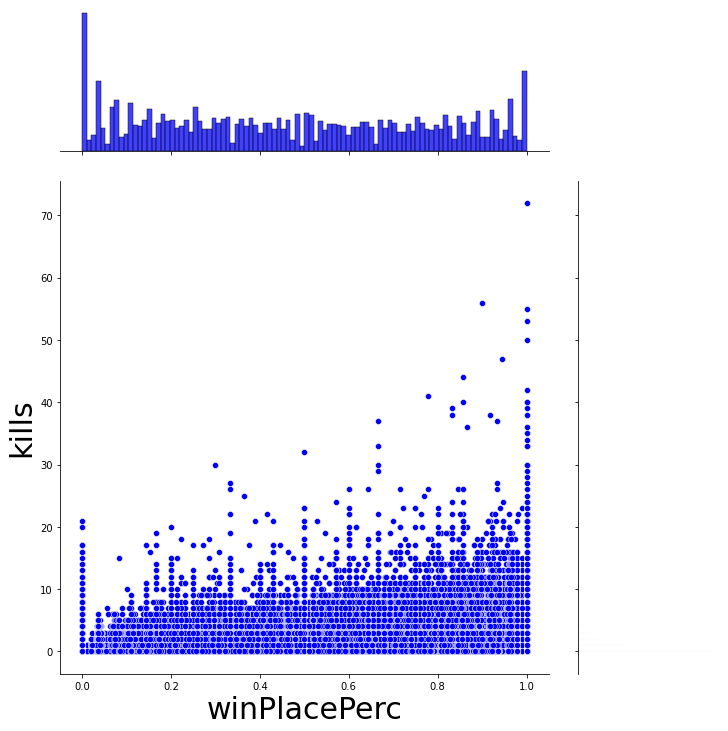

In [4]:
df = raw_data.copy()
ax1 = sns.jointplot(x="winPlacePerc", y="kills", data=df, height=10, ratio=3, color="b")
ax1.set_axis_labels(xlabel='winPlacePerc',ylabel='kills', fontsize=30)
plt.show()

0~5킬 사이의 경우 상관성이 없다해도 무방하지만 6킬 이상부턴 높은 등수를 차지하는 비율이 점점 올라간다.

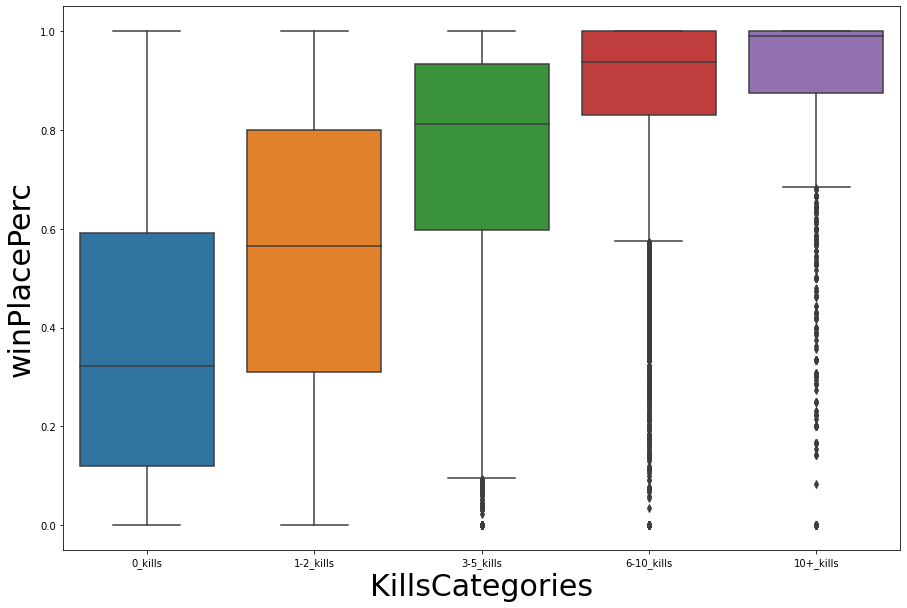

In [5]:
df['KillsCate'] = pd.cut(df['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,10))
ax2 = sns.boxplot(x="KillsCate", y="winPlacePerc", data=df)
ax2.set_xlabel('KillsCategories', fontsize=30)
ax2.set_ylabel('winPlacePerc', fontsize=30)
plt.show()

킬 수에 따라 카테고리로 분류하면 더 확실한 차이를 볼 수 있다.

## (2) Groups
총 그룹이 적을수록 치킨을 잘 먹는가

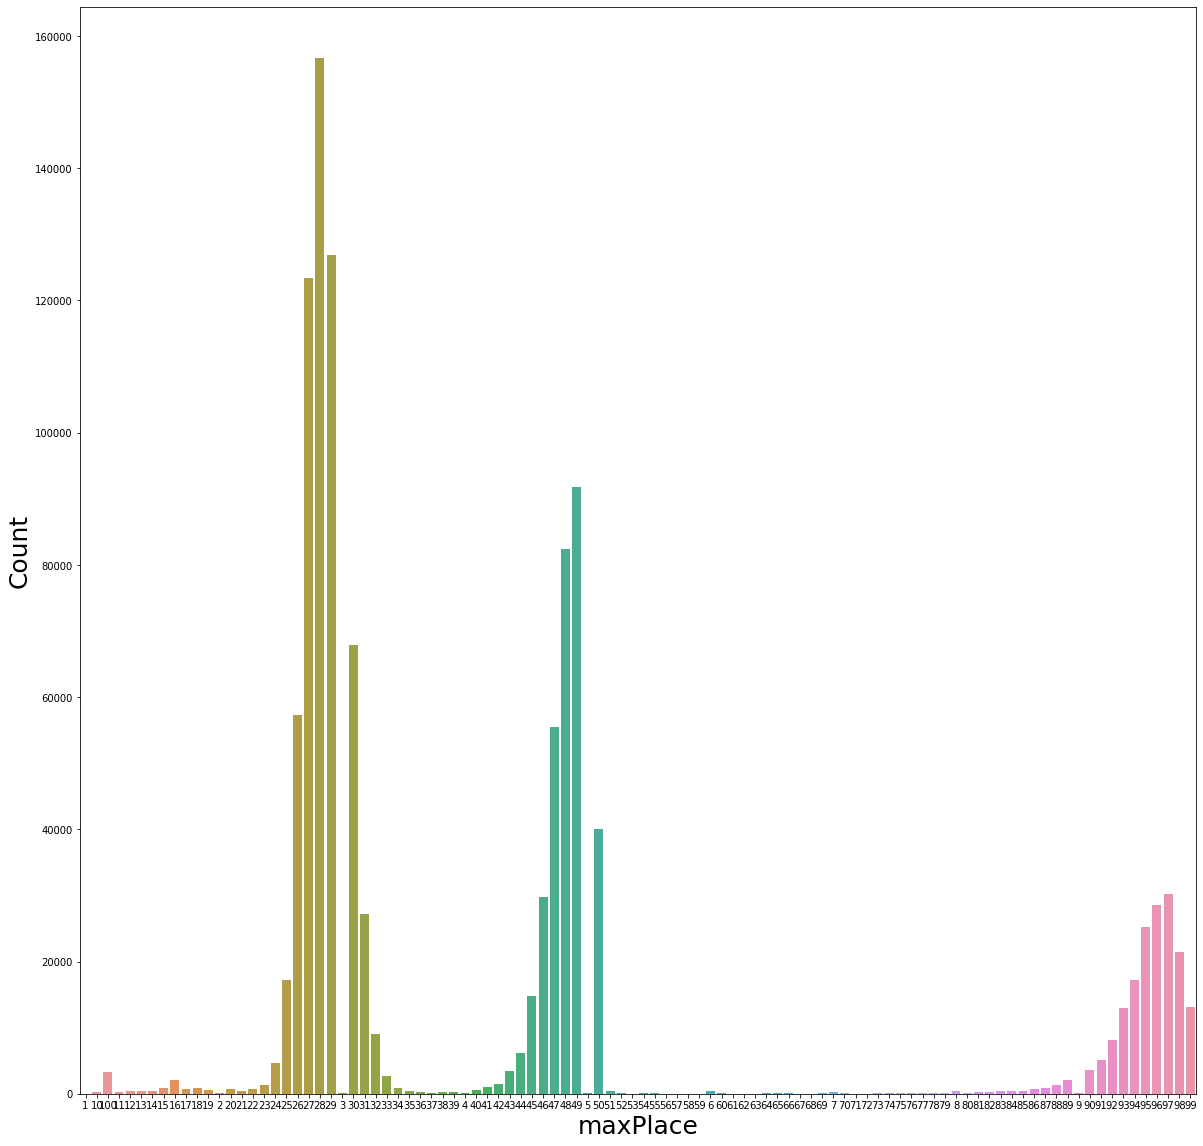

In [6]:
df = raw_data.copy()
plt.figure(figsize=(20, 20))
sns.countplot(df['maxPlace'].astype('str').sort_values())
plt.xlabel('maxPlace', fontsize=25)
plt.ylabel('Count', fontsize=25)
plt.show()

특정 총 그룹수가 집중적으로 나타나고 있다. 500번 이상 나타는 그룹들은 24 ~ 33그룹, 43 ~ 50그룹, 86 ~ 99그룹으로 각각 스쿼드, 듀오, 솔로 매치타입으로 인한 현상으로 보여진다. 세 가지 형태로 나누어 density plot을 그려보았다. 우리의 목표는 우승이므로 0.5 이상(중간 순위 이상)의 경우를 확인해보겠다.

Text(0.5, 1.0, 'squad distribution')

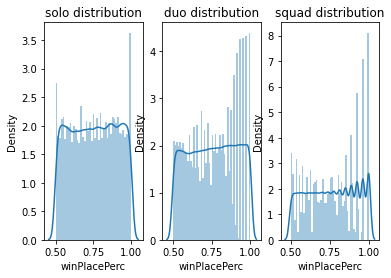

In [7]:
squad_group = df[(df['maxPlace']>=24) & (df['maxPlace'] <= 33) & (df['winPlacePerc'] >= 0.5)]
duo_group = df[(df['maxPlace']>=43) & (df['maxPlace'] <= 50) & (df['winPlacePerc'] >= 0.5)]
solo_group = df[(df['maxPlace']>=86) & (df['maxPlace'] <= 99) & (df['winPlacePerc'] >= 0.5)]

fig, ax = plt.subplots(ncols=3)
sns.distplot(solo_group['winPlacePerc'], ax=ax[0])
sns.distplot(duo_group['winPlacePerc'], ax=ax[1])
sns.distplot(squad_group['winPlacePerc'], ax=ax[2])
ax[0].set_title('solo distribution')
ax[1].set_title('duo distribution')
ax[2].set_title('squad distribution')

확실히 솔로에서 스쿼드로 갈수록 상위권을 기록한 플레이어들이 적음을 알 수 있다. 다만 솔로와는 다르게 듀오와 스쿼드의 경우 마지막까지 살아남은 팀원의 기록이 팀 전체의 기록으로 측정되어 솔로에 비해 높은 순위를 차지할 가능성이 높음을 인지하여야 한다.

## (3) Moving Distance
많이 이동할수록 치킨을 잘 먹는가

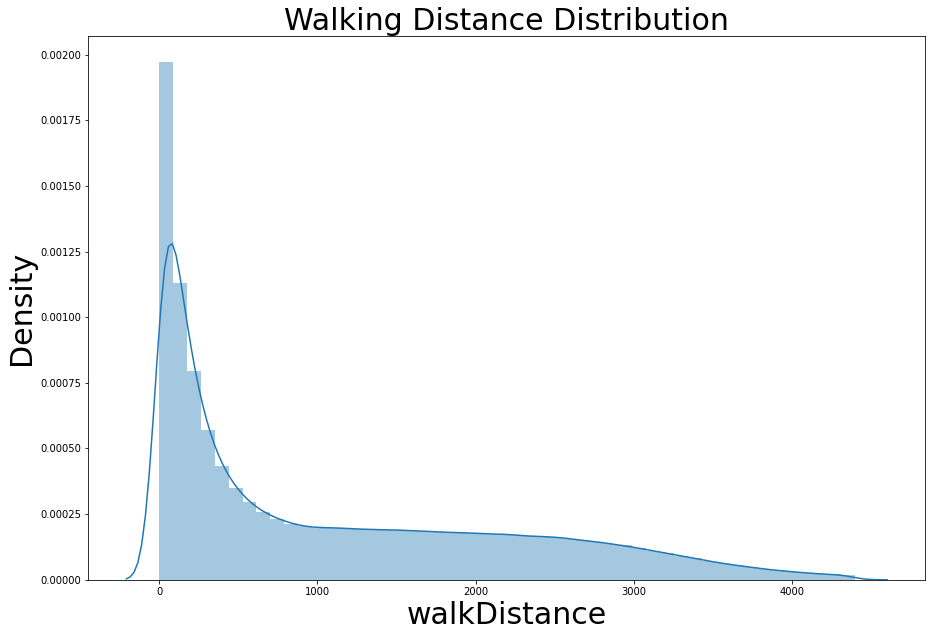

In [9]:
df = raw_data.copy()
df2 = df[df['walkDistance'] < df['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=30)
sns.distplot(df2['walkDistance'])
plt.xlabel('walkDistance', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.show()

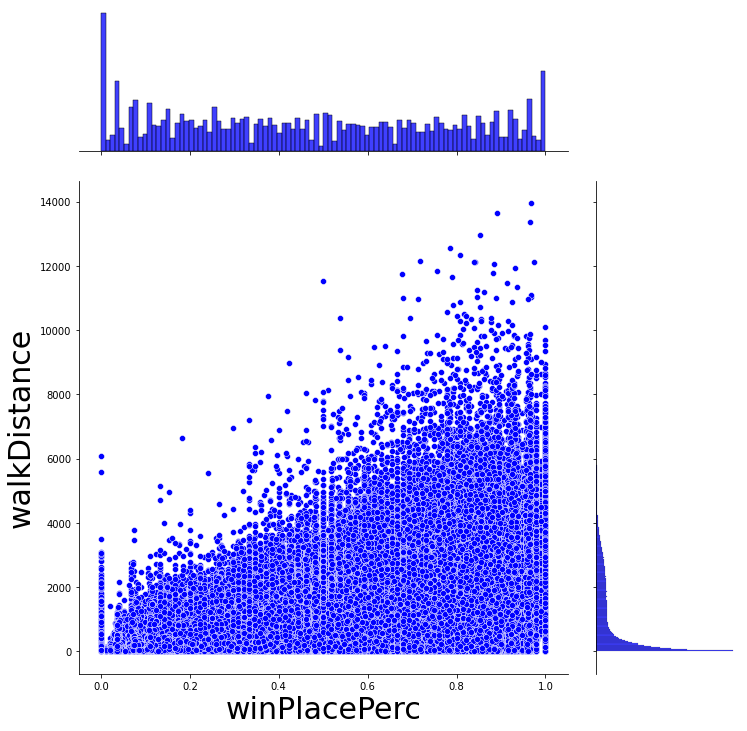

In [10]:
ax = sns.jointplot(x="winPlacePerc", y="walkDistance", data=df, height=10, ratio=3, color="b")
ax.set_axis_labels(xlabel='winPlacePerc', ylabel='walkDistance', fontsize=30)
plt.show()

도보 이동거리와 순위는 높은 상관관계를 가지고 있음을 알 수 있다.하지만 순위가 높을 수록 살아있는 시간이 길고, 게임의 특성 상 죽을 때까지 계속 움직이는 것이 보통이기 때문에 생존(매치) 시간과 더불어 조심히 접근해야 한다. 회귀모형을 활용할 경우 높은 상관계수로 인해 타깃(winPlacePerc)에 좋지 않은 영향을 끼치기 때문이다.

## (4) Match Duration
매치 시간이 길수록 치킨을 잘 먹는가

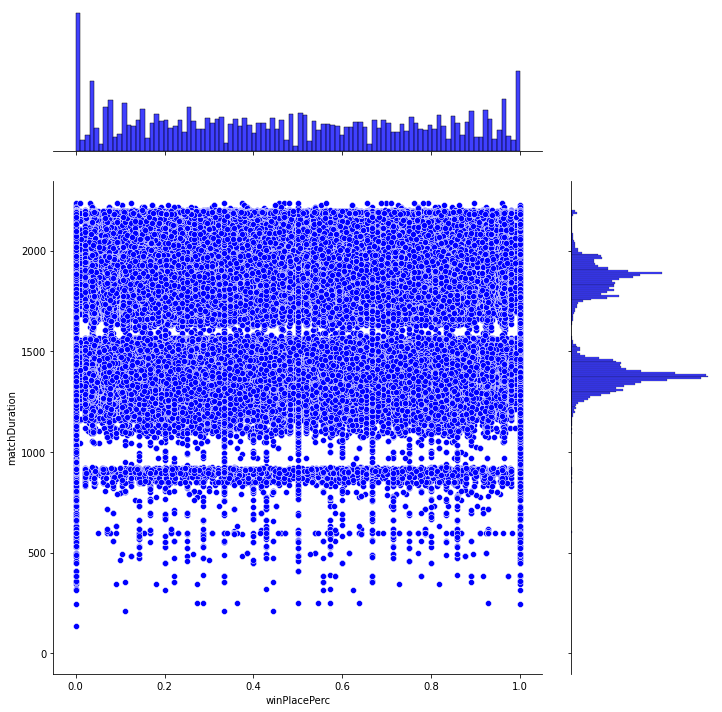

In [11]:
df = raw_data.copy()
sns.jointplot(x="winPlacePerc", y="matchDuration", data=df, height=10, ratio=3, color="b")
plt.show()

매치 시간과 순위의 관계는 jointplot으로 확인하기엔 무리가 있다. 따라서 1등을 한 경우만 보고자한다.

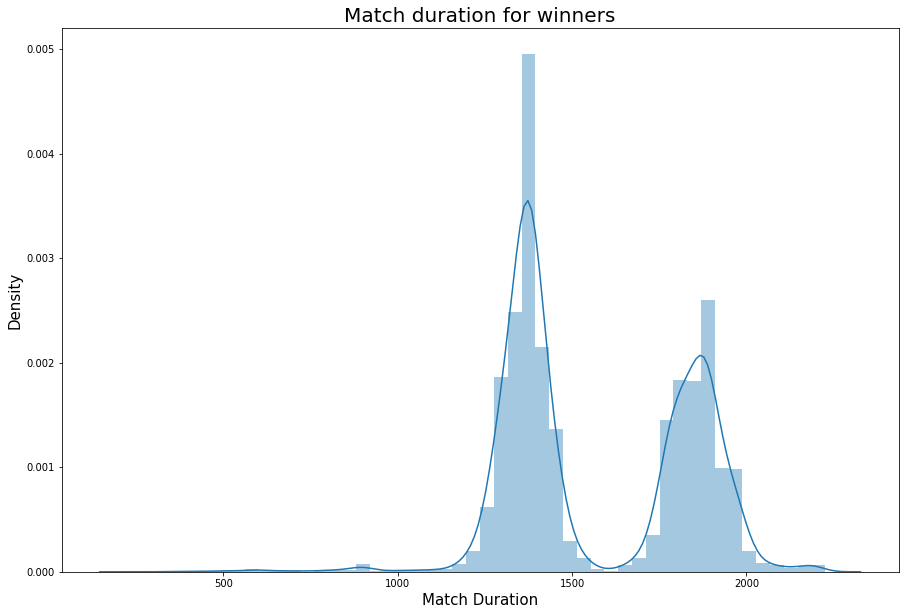

In [12]:
winners = df[df['winPlacePerc'] == 1]
plt.figure(figsize=(15,10))
plt.title('Match duration for winners',fontsize=20)
sns.distplot(winners['matchDuration'])
plt.xlabel('Match Duration', fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.show()

1200 ~ 1500초 사이와 1700 ~ 2000초 사이에 대부분 밀집되어 있는 것은 게임이 상대적으로 빨리 끝나면 블루존 5 ~ 6단계, 늦으면 8 ~ 9단계(점 블루존)에서 끝나는 특성으로부터 도출된 결과이다. 8X8 맵과 4X4맵의 크기 차이가 그래프에 반영된 결과이기에 1600초 ± 100초 부근은 분포가 거의 없다. 매치 시간(matchDuration)은 타깃을 예측하는데 활용할 변수로는 적절하지 않다.

## (5) Players in Group
같은 팀이 많을수록 킬을 많이 하고 치킨을 잘 먹는가

In [33]:
df = raw_data.copy()
solo = df[(df['players_in_team'] == 1)]
duo = df[(df['players_in_team'] == 2)]
squad = df[df['players_in_team'] >= 3]

print("솔로는 {}({:.2f}%)번, 듀오는 {}({:.2f}%)번, 스쿼드는 {}({:.2f}%)번 나타난다".format(len(solo), 100*len(solo)/len(df), 
                                                                                len(duo), 100*len(duo)/len(df), 
                                                                                len(squad), 100*len(squad)/len(df)))

솔로는 678763(61.05%)번, 듀오는 308142(27.72%)번, 스쿼드는 124837(11.23%)번 나타난다


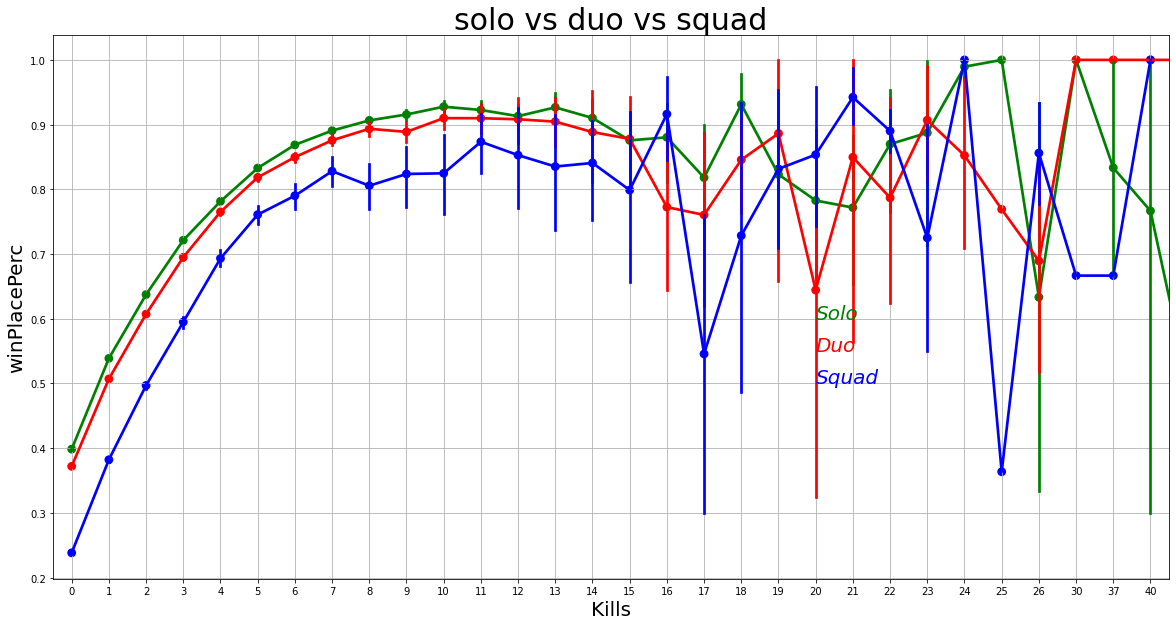

In [34]:
f, ax1 = plt.subplots(figsize=(20,10))
sns.pointplot(x='kills', y='winPlacePerc', data=solo, color='green', alpha=0.8)
sns.pointplot(x='kills', y='winPlacePerc', data=duo, color='red', alpha=0.8)
sns.pointplot(x='kills', y='winPlacePerc', data=squad, color='blue', alpha=0.8)
plt.text(20,0.6,'Solo',color='green',fontsize = 20,style = 'italic')
plt.text(20,0.55,'Duo',color='red',fontsize = 20,style = 'italic')
plt.text(20,0.5,'Squad',color='blue',fontsize = 20,style = 'italic')
plt.xlabel('Kills', fontsize=20)
plt.ylabel("winPlacePerc", fontsize=20)
plt.title('solo vs duo vs squad', fontsize=30)
plt.grid()
plt.show()

킬 수가 올라갈수록 순위가 높아지는 경향은 솔로, 듀오, 스쿼드 모두 비슷하게 나타나고 있다. 모델 적용 시 가중치를 부여하는 등의 추가조치는 필요 없을 것으로 보인다.

## (6) Multivariate Analysis
변수들간의 상관관계는 어떤가

<AxesSubplot:>

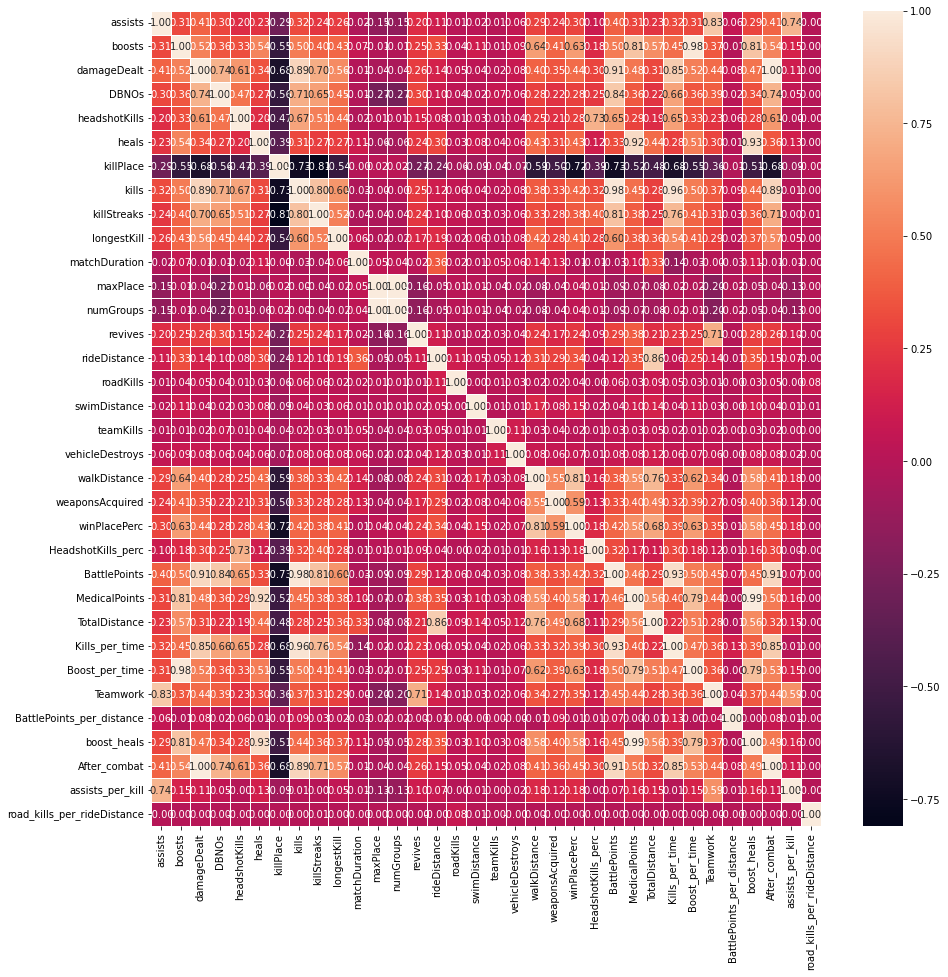

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

df = raw_data.copy()
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

타깃(winPlacePerc)은 boosts, walkDistance, weaponsAcquired, TotalDistance, Boost_per_time과 강한 양의 상관관계를 가진다. 또한 killPlace와는 상관계수가 -0.72로 강한 음의 상관관계를 가진다.